Лабораторная работа №3

Решающие деревья

In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay,  mean_absolute_error

Классификация (стандартный бейзлайн)

Датасет для классификации - Spotify Tracks Dataset

Цель данной работы - определение того, будет ли трек популярным (за популярность будем считать показатель popularity выше или равный 70).

В качестве метрик качества будут выступать:

1. Accuracy - доля правильных классификаций.

2. Precision - точность (True_positive / True_positive + False_positive). Минимизирует ложно положительные результаты.

3. Recall - полнота (True_positive / True_positive + False_negative). Минимизирует ложно отрицательные результаты.

4. F1 - взвешенное среднее Precision и Recall.

Импортирование датасета из файла (https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

In [2]:
tracks = pd.read_csv('dataset.csv', index_col = 0)
tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Размер датасета

In [3]:
tracks.shape

(114000, 20)

Информация о типах данных

In [4]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

Очевидно, что id не влияет на популярность, удалим.

In [5]:
tracks = tracks.drop(['track_id'], axis = 1)

Проведем label encoding текстовых полей artists, album_name, track_name, track_genre

In [6]:
artists = tracks['artists']
album_name = tracks['album_name']
track_name = tracks['track_name']
track_genre = tracks['track_genre']

label_encoder = LabelEncoder()
encoded_artists = label_encoder.fit_transform(artists)
encoded_album_name = label_encoder.fit_transform(album_name)
encoded_track_name = label_encoder.fit_transform(track_name)
encoded_track_genre = label_encoder.fit_transform(track_genre)

tracks['artists'] = encoded_artists
tracks['album_name'] = encoded_album_name
tracks['track_name'] = encoded_track_name
tracks['track_genre'] = encoded_track_genre

tracks.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,10357,8100,11741,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0
1,3287,14796,22528,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0
2,12397,39162,60774,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0
3,14839,8580,9580,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0
4,5255,16899,25689,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0


Введем новое поле is_popular, зависящее от popularity, для более простой оценки популярности.

In [7]:
popularity_rate = 70.0

tracks['is_popular'] = np.select([(tracks['popularity'] >= popularity_rate), (tracks['popularity'] < popularity_rate)], [1, 0])
tracks.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,is_popular
0,10357,8100,11741,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0,1
1,3287,14796,22528,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0,0
2,12397,39162,60774,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0,0
3,14839,8580,9580,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0,1
4,5255,16899,25689,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0,1


Разделим датасет на train и test.

При этом поля is_popular и popularity удалим из входных данных, а выходными будет поле is_popular.

In [51]:
y_classifier = tracks['is_popular']
X_classifier = tracks.drop(["is_popular", "popularity"], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
X_classifier = pd.DataFrame(simpleimputer.fit_transform(X_classifier))

X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(X_classifier, y_classifier, test_size = 0.1, random_state = 228, shuffle = True)

Обучение модели и вывод метрик.

In [11]:
dt_classifier = DecisionTreeClassifier(random_state=228)
dt_model_classifier = dt_classifier.fit(X_train_classifier, y_train_classifier)

dt_predictions_classifier = dt_classifier.predict(X_test_classifier)

accuracy = accuracy_score(y_test_classifier, dt_predictions_classifier)
f1 = f1_score(y_test_classifier, dt_predictions_classifier)
precision = precision_score(y_test_classifier, dt_predictions_classifier)
recall = recall_score(y_test_classifier, dt_predictions_classifier)

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"precision: {precision}")
print(f"recall: {recall}")

accuracy: 0.9449122807017544
f1: 0.4757929883138564
precision: 0.4377880184331797
recall: 0.5210237659963437


Матрица ошибок

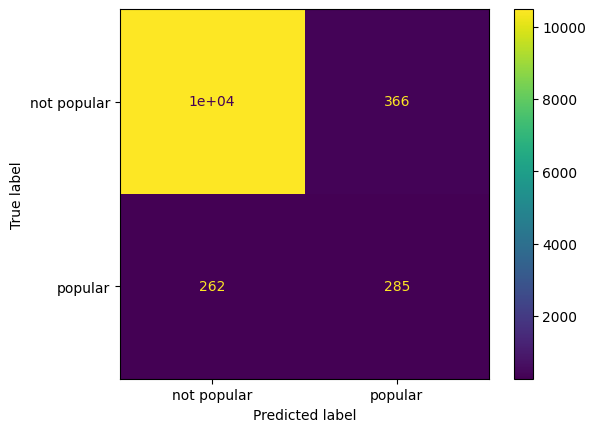

In [12]:
cm = confusion_matrix(y_test_classifier, dt_predictions_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular'])
plt.yticks([0, 1], ['not popular', 'popular'])
plt.show()

Регрессия (стандартный бейзлайн)

Датасет для регрессии - IGN Games

Цель данной работы - предугадать оценку игры на IGN по её параметрам.

В качестве метрики качества будут выступать Mean Absolute Error - средняя абсолютная ошибка.

Импортирование датасета из файла (https://www.kaggle.com/datasets/joebeachcapital/ign-games)

In [13]:
games = pd.read_csv('ign.csv', index_col = 0)
games.head()

,score_phrase,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
0,Amazing,LittleBigPlanet PS Vita,/games/littlebigplanet-vita/vita-98907,PlayStation Vita,9.0,Platformer,Y,2012,9,12
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,/games/littlebigplanet-ps-vita-marvel-super-he...,PlayStation Vita,9.0,Platformer,Y,2012,9,12
2,Great,Splice: Tree of Life,/games/splice/ipad-141070,iPad,8.5,Puzzle,N,2012,9,12
3,Great,NHL 13,/games/nhl-13/xbox-360-128182,Xbox 360,8.5,Sports,N,2012,9,11
4,Great,NHL 13,/games/nhl-13/ps3-128181,PlayStation 3,8.5,Sports,N,2012,9,11


Размер датасета

In [14]:
games.shape

(18625, 10)

Информация о типах данных

In [15]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18625 entries, 0 to 18624
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score_phrase    18625 non-null  object 
 1   title           18625 non-null  object 
 2   url             18625 non-null  object 
 3   platform        18625 non-null  object 
 4   score           18625 non-null  float64
 5   genre           18589 non-null  object 
 6   editors_choice  18625 non-null  object 
 7   release_year    18625 non-null  int64  
 8   release_month   18625 non-null  int64  
 9   release_day     18625 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 1.6+ MB


Удалим столбец score_phrase, так как он является текстовым алиасом столбца score.



In [16]:
games = games.drop(['score_phrase'], axis = 1)

Проведем label encoding текстовых полей

In [17]:
title = games['title']
url = games['url']
platform = games['platform']
genre = games['genre']
editors_choice = games['editors_choice']

label_encoder = LabelEncoder()
encoded_title = label_encoder.fit_transform(title)
encoded_url = label_encoder.fit_transform(url)
encoded_platform = label_encoder.fit_transform(platform)
encoded_genre = label_encoder.fit_transform(genre)
encoded_editors_choice = label_encoder.fit_transform(editors_choice)


games['title'] = encoded_title
games['url'] = encoded_url
games['platform'] = encoded_platform
games['genre'] = encoded_genre
games['editors_choice'] = encoded_editors_choice

games.head()

,title,url,platform,score,genre,editors_choice,release_year,release_month,release_day
0,5684,8389,35,9.0,63,1,2012,9,12
1,5685,8386,35,9.0,63,1,2012,9,12
2,9764,14318,56,8.5,68,0,2012,9,12
3,7050,10812,54,8.5,93,0,2012,9,11
4,7050,10811,32,8.5,93,0,2012,9,11


Разделим датасет на train и test

In [18]:
y_regression = games['score']
X_regression = games.drop(['score'], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
X_regression = pd.DataFrame(simpleimputer.fit_transform(X_regression))

X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression, y_regression, test_size = 0.1, random_state = 228, shuffle = True)

Обучение модели и вывод метрик

In [20]:
dt_regression = DecisionTreeRegressor(random_state=228)
dt_model_regression = dt_regression.fit(X_train_regression, y_train_regression)

dt_predictions_regression = dt_regression.predict(X_test_regression)

mae = mean_absolute_error(y_test_regression, dt_predictions_regression)
print(f"MAE: {mae}")

MAE: 1.2866881374127752


Также оценим небольшую выборку из первых 100 игр, сравним значения модели и реальные оценки на графике.

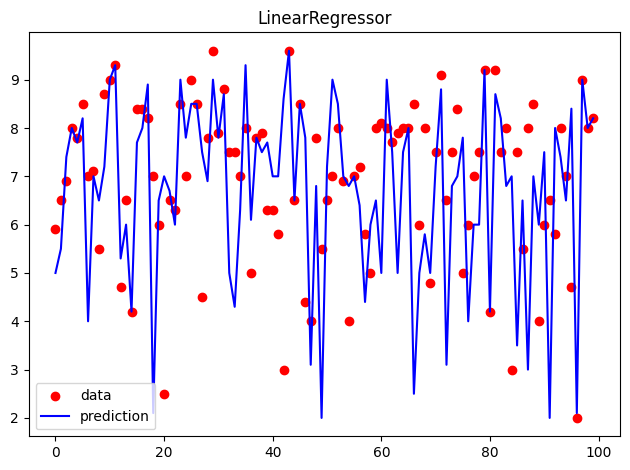

In [21]:
count = 100

plt.scatter(np.arange(0, len(y_test_regression))[0:count], list(y_test_regression)[0:count], color="red", label="data")
plt.plot(np.arange(0, len(y_test_regression))[0:count], dt_predictions_regression[0:count], color="blue", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("LinearRegressor")

plt.tight_layout()
plt.show()

Классификация (улучшенный бейзлайн)

Гипотезы:

1) если убрать artists, album_name, track_name, то обучение будет идти лучше (эти параметры нормально не могут быть представлены в числовом виде, и скорее всего создают шум)

2) можно убрать кореллирующие данные (чтобы они не усиливали друг друга и не давали отклонения)

3) можно убрать нулевые данные, повторяющиеся (непонятно что делать с такими данными, лучше от них избавиться)

4) воспользуемся Grid Search с кросс-валидацией для оптимизации модели.

В этот раз не будем делать one-hot, ибо в тот раз оно показало себя хуже



In [22]:
opt_tracks = tracks
opt_tracks = opt_tracks.drop(['artists'], axis = 1)
opt_tracks = opt_tracks.drop(['album_name'], axis = 1)
opt_tracks = opt_tracks.drop(['track_name'], axis = 1)
opt_tracks.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,is_popular
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,0,1
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,0,0
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,0,0
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,0,1
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,0,1


Построим матрицу корреляции для удаления коррелирующих значений.

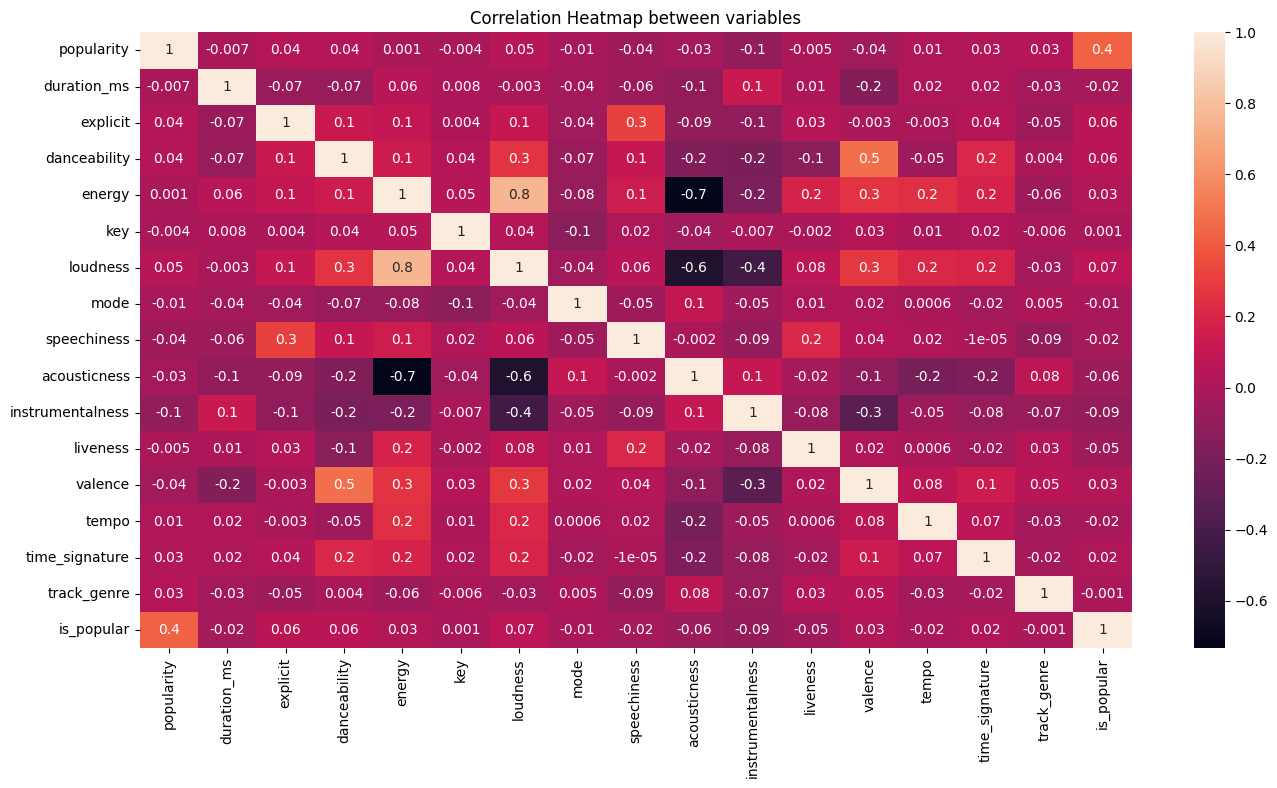

In [23]:
import seaborn as sns

corr_table = opt_tracks.corr(method = "pearson")

plt.figure(figsize=(16,8))
sns.heatmap(corr_table, annot=True, fmt=".1g")
plt.title("Correlation Heatmap between variables")
plt.show()

Больше всего кореллирует energy, уберем

In [24]:
opt_tracks = opt_tracks.drop(["energy"], axis = 1)

Разделим датасет и проведем кросс-валидацию

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

opt_y_classifier = opt_tracks['is_popular']
opt_X_classifier = opt_tracks.drop(["is_popular", "popularity"], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
opt_X_classifier = pd.DataFrame(simpleimputer.fit_transform(opt_X_classifier))

opt_X_train_classifier, opt_X_test_classifier, opt_y_train_classifier, opt_y_test_classifier = train_test_split(opt_X_classifier, opt_y_classifier, test_size = 0.1, random_state = 228, shuffle = True)


opt_X_train_classifier = scaler.fit_transform(opt_X_train_classifier)
opt_X_test_classifier = scaler.fit_transform(opt_X_test_classifier)

param_grid = {
   'max_depth': [1, 3, 5, 10, None],
   'min_samples_split': [1, 2, 5, 10],
   'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=228), param_grid, cv=5)
grid_search.fit(opt_X_train_classifier, opt_y_train_classifier)

print("Лучшие параметры: ", grid_search.best_params_)

Лучшие параметры:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


Обучение и вывод метрик (также применим масштабирование данных)



accuracy: 0.9518421052631579
f1: 0.0
precision: 0.0
recall: 0.0


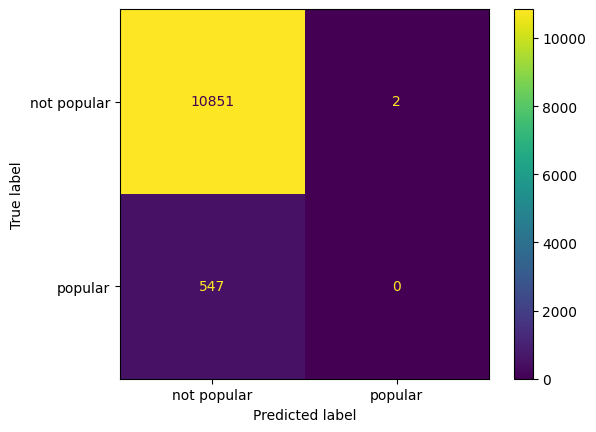

In [27]:
opt_dt_classifier = DecisionTreeClassifier(random_state=228, max_depth=5, min_samples_leaf=1, min_samples_split=5)
opt_dt_model_classifier = opt_dt_classifier.fit(opt_X_train_classifier, opt_y_train_classifier)

opt_dt_predictions_classifier = opt_dt_classifier.predict(opt_X_test_classifier)

accuracy = accuracy_score(opt_y_test_classifier, opt_dt_predictions_classifier)
f1 = f1_score(opt_y_test_classifier, opt_dt_predictions_classifier)
precision = precision_score(opt_y_test_classifier, opt_dt_predictions_classifier)
recall = recall_score(opt_y_test_classifier, opt_dt_predictions_classifier)

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"precision: {precision}")
print(f"recall: {recall}")

cm = confusion_matrix(opt_y_test_classifier, opt_dt_predictions_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular'])
plt.yticks([0, 1], ['not popular', 'popular'])
plt.show()

Регрессия (улучшенный бейзлайн)

Гипотезы:

1) title и url, скорее всего, не играют никакой роли, к тому же численно не представимы.

2) можно убрать кореллирующие данные (чтобы они не усиливали друг друга и не давали отклонения)

3) можно убрать нулевые данные, повторяющиеся (непонятно что делать с такими данными, лучше от них избавиться)

4) можно привести 3 столбца, отвечающие за дату, к единому числу. Благодаря этому, дата выхода станет единым аспектом, а не тремя, к тому же можно будет однозначно сказать, какая дата "больше".

5) попробуем применить масштабирование StandartScaler ко входным данным

6) воспользуемся Grid Search с кросс-валидацией для оптимизации модели.

In [94]:
opt_games = games
opt_games = opt_games.drop(['title'], axis = 1)
opt_games = opt_games.drop(['url'], axis = 1)
opt_games.head()

,platform,score,genre,editors_choice,release_year,release_month,release_day
0,35,9.0,63,1,2012,9,12
1,35,9.0,63,1,2012,9,12
2,56,8.5,68,0,2012,9,12
3,54,8.5,93,0,2012,9,11
4,32,8.5,93,0,2012,9,11


Посмотрим на матрицу корреляции

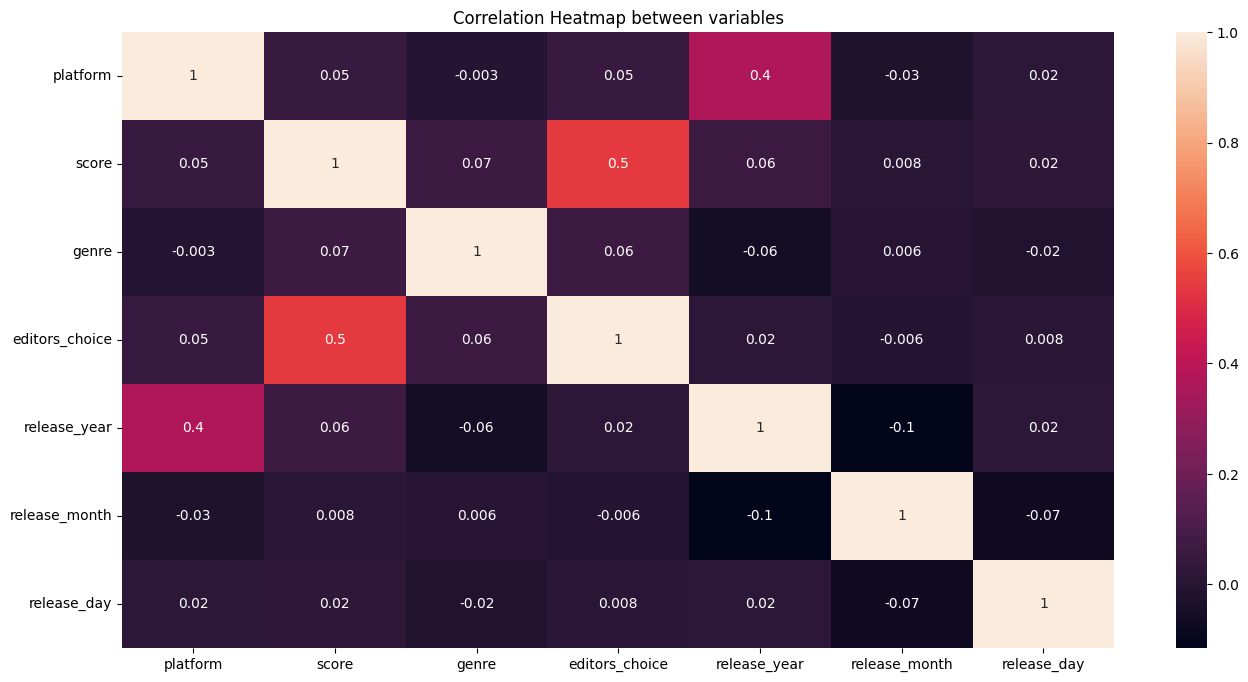

In [95]:
import seaborn as sns

corr_table = opt_games.corr(method = "pearson")

plt.figure(figsize=(16,8))
sns.heatmap(corr_table, annot=True, fmt=".1g")
plt.title("Correlation Heatmap between variables")
plt.show()

Сильно кореллирующих данных нет

Приведем дату к единому числу (можно сказать, что в колонке timestamp будет число, отображающее насколько "старая" игра)

In [96]:
from datetime import date

release_year = opt_games.release_year
release_month = opt_games.release_month
release_day = opt_games.release_day

timestamps = []
for i in range(len(release_year)):
    timestamps.append((date.today() - date(release_year[i], release_month[i], release_day[i])).days)

opt_games = opt_games.drop(["release_year"], axis = 1)
opt_games = opt_games.drop(["release_month"], axis = 1)
opt_games = opt_games.drop(["release_day"], axis = 1)
opt_games['timestamp'] = timestamps

opt_games.head()

,platform,score,genre,editors_choice,timestamp
0,35,9.0,63,1,4498
1,35,9.0,63,1,4498
2,56,8.5,68,0,4498
3,54,8.5,93,0,4499
4,32,8.5,93,0,4499


Разделим датасет и применим GridSearch для поиска гиперпараметров

In [97]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

opt_y_regression = opt_games['score']
opt_X_regression = opt_games.drop(['score'], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
opt_X_regression = pd.DataFrame(simpleimputer.fit_transform(opt_X_regression))

opt_X_train_regression, opt_X_test_regression, opt_y_train_regression, opt_y_test_regression = train_test_split(opt_X_regression, opt_y_regression, test_size = 0.1, random_state = 228, shuffle = True)

opt_X_train_regression = scaler.fit_transform(opt_X_train_regression)
opt_X_test_regression = scaler.fit_transform(opt_X_test_regression)


param_grid = {
   'max_depth': [1, 3, 5, 10, None],
   'min_samples_split': [1, 2, 5, 10],
   'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(DecisionTreeRegressor(random_state=228), param_grid, cv=5)
grid_search.fit(opt_X_train_regression, opt_y_train_regression)

print("Лучшие параметры: ", grid_search.best_params_)

Лучшие параметры:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}


Oбучение и вывод метрик (также применим масштабирование данных)

MAE: 1.091517695685308


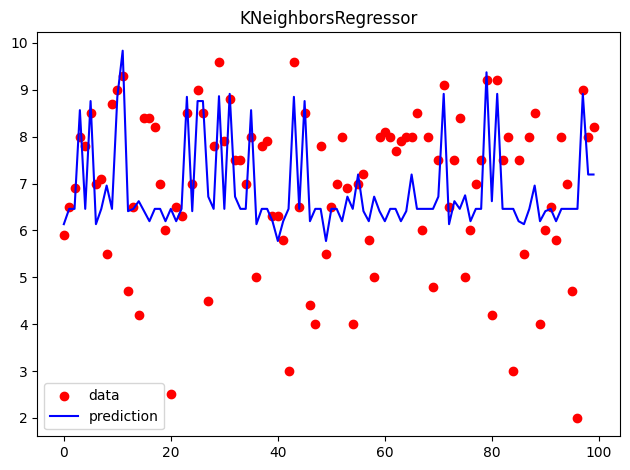

In [32]:
opt_dt_regression = DecisionTreeRegressor(random_state=228, max_depth=5, min_samples_leaf=2, min_samples_split=10)
opt_dt_model_regression = opt_dt_regression.fit(opt_X_train_regression, opt_y_train_regression)

opt_dt_predictions_regression = opt_dt_regression.predict(opt_X_test_regression)

mae = mean_absolute_error(opt_y_test_regression, opt_dt_predictions_regression)
print(f"MAE: {mae}")

count = 100

plt.scatter(np.arange(0, len(opt_y_test_regression))[0:count], list(opt_y_test_regression)[0:count], color="red", label="data")
plt.plot(np.arange(0, len(opt_y_test_regression))[0:count], opt_dt_predictions_regression[0:count], color="blue", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("KNeighborsRegressor")

plt.tight_layout()
plt.show()


Самостоятельная имплементация

Везде брались те же датасеты


Классификация

In [55]:
class HandmadeDecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (self.max_depth is not None and depth >= self.max_depth) or n_samples < self.min_samples_split:
            return self._leaf_value(y)
        split = self._best_split(X, y)
        if split is None:
            return self._leaf_value(y)
        feature_index, threshold, left_mask, right_mask = split
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return {
            'feature_index': feature_index,
            'threshold': threshold,
            'left': left_tree,
            'right': right_tree
        }

    def fit(self, X, y):
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        self.tree = self._build_tree(X, y)

    def _predict_sample(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature_value = x.iloc[tree['feature_index']]
        if feature_value <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict_sample(row, self.tree) for _, row in X.iterrows()])

    @staticmethod
    def gini(y):
        m = len(y)
        if m == 0:
            return 0
        p = np.bincount(y) / m
        return 1 - np.sum(p ** 2)

    def _gini_impurity(self, left_y, right_y):
        total = len(left_y) + len(right_y)
        return (len(left_y) / total) * self.gini(left_y) + (len(right_y) / total) * self.gini(right_y)

    def _leaf_value(self, y):
        return np.bincount(y).argmax()

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_split = None
        n_samples, n_features = X.shape
        for feature_index in range(n_features):
            thresholds = np.unique(X.iloc[:, feature_index])
            for threshold in thresholds:
                left_mask = X.iloc[:, feature_index] <= threshold
                right_mask = ~left_mask
                left_y, right_y = y[left_mask], y[right_mask]
                if len(left_y) >= self.min_samples_leaf and len(right_y) >= self.min_samples_leaf:
                    gini = self._gini_impurity(left_y, right_y)
                    if gini < best_gini:
                        best_gini = gini
                        best_split = (feature_index, threshold, left_mask, right_mask)
        return best_split

Обрежем датасет (на исходном я устал ждать спустя 1.5 часа, даже на 1000 оно работает 6 минут)

In [70]:
popular = tracks[tracks['is_popular'] == 1]
popular_trim = popular.iloc[0:100]

tracks_trimmed = pd.concat([(tracks[tracks['is_popular'] == 0]).iloc[0:900], popular_trim])

y_classifier = tracks_trimmed['is_popular']
X_classifier = tracks_trimmed.drop(["is_popular", "popularity"], axis = "columns")

print(len(tracks_trimmed[tracks_trimmed['is_popular'] == 1]))

simpleimputer = SimpleImputer(strategy='mean')
X_classifier = pd.DataFrame(simpleimputer.fit_transform(X_classifier))

X_train_classifier, X_test_classifier, y_train_classifier, y_test_classifier = train_test_split(X_classifier, y_classifier, test_size = 0.2, random_state = 228, shuffle = True)

100


Базовый бейзлайн

accuracy: 0.97
f1: 0.8421052631578947
precision: 0.7272727272727273
recall: 1.0


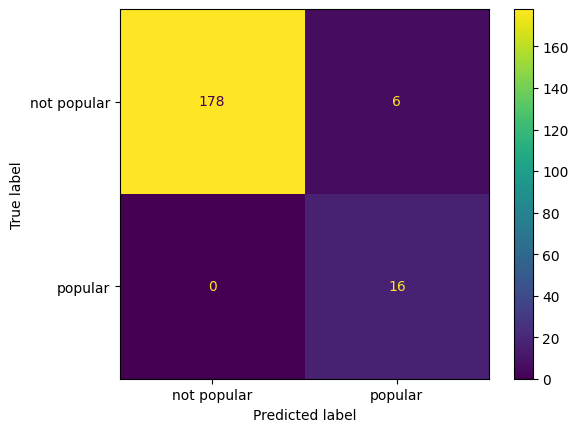

In [71]:
dt_classifier = HandmadeDecisionTreeClassifier()
dt_model_classifier = dt_classifier.fit(X_train_classifier, y_train_classifier)

dt_predictions_classifier = dt_classifier.predict(X_test_classifier)

accuracy = accuracy_score(y_test_classifier, dt_predictions_classifier)
f1 = f1_score(y_test_classifier, dt_predictions_classifier)
precision = precision_score(y_test_classifier, dt_predictions_classifier)
recall = recall_score(y_test_classifier, dt_predictions_classifier)

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"precision: {precision}")
print(f"recall: {recall}")

cm = confusion_matrix(y_test_classifier, dt_predictions_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular'])
plt.yticks([0, 1], ['not popular', 'popular'])
plt.show()

Обрезка датасета

In [76]:
opt_popular = opt_tracks[opt_tracks['is_popular'] == 1]
opt_popular_trim = opt_popular.iloc[0:100]

opt_tracks_trimmed = pd.concat([(opt_tracks[opt_tracks['is_popular'] == 0]).iloc[0:900], opt_popular_trim])

opt_y_classifier = opt_tracks_trimmed['is_popular']
opt_X_classifier = opt_tracks_trimmed.drop(["is_popular", "popularity"], axis = "columns")

print(len(opt_tracks_trimmed[opt_tracks_trimmed['is_popular'] == 1]))

simpleimputer = SimpleImputer(strategy='mean')
opt_X_classifier = pd.DataFrame(simpleimputer.fit_transform(opt_X_classifier))

opt_X_train_classifier, opt_X_test_classifier, opt_y_train_classifier, opt_y_test_classifier = train_test_split(opt_X_classifier, opt_y_classifier, test_size = 0.2, random_state = 228, shuffle = True)

100


Улучшенный бейзлайн (без кросс-валидации)

accuracy: 0.935
f1: 0.7111111111111111
precision: 0.5517241379310345
recall: 1.0


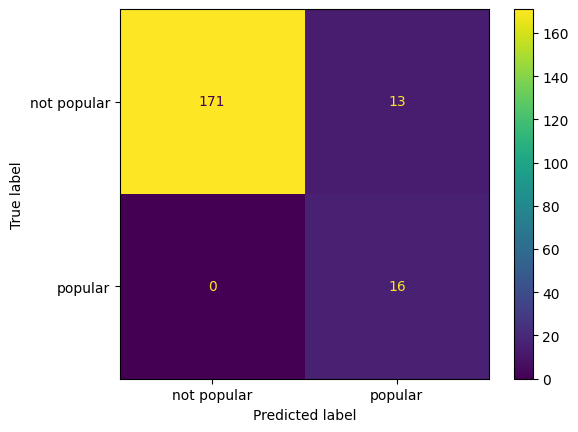

In [80]:
opt_dt_classifier = HandmadeDecisionTreeClassifier()
opt_dt_model_classifier = opt_dt_classifier.fit(opt_X_train_classifier, opt_y_train_classifier)

opt_dt_predictions_classifier = opt_dt_classifier.predict(opt_X_test_classifier)

accuracy = accuracy_score(opt_y_test_classifier, opt_dt_predictions_classifier)
f1 = f1_score(opt_y_test_classifier, opt_dt_predictions_classifier)
precision = precision_score(opt_y_test_classifier, opt_dt_predictions_classifier)
recall = recall_score(opt_y_test_classifier, opt_dt_predictions_classifier)

print(f"accuracy: {accuracy}")
print(f"f1: {f1}")
print(f"precision: {precision}")
print(f"recall: {recall}")

cm = confusion_matrix(opt_y_test_classifier, opt_dt_predictions_classifier)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0, 1], ['not popular', 'popular'])
plt.yticks([0, 1], ['not popular', 'popular'])
plt.show()

Регрессия

In [82]:
class HandmadeDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if (self.max_depth is not None and depth >= self.max_depth) or n_samples < self.min_samples_split:
            return self._leaf_value(y)
        split = self._best_split(X, y)
        if split is None:
            return self._leaf_value(y)
        feature_index, threshold, left_mask, right_mask = split
        left_tree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return {
            'feature_index': feature_index,
            'threshold': threshold,
            'left': left_tree,
            'right': right_tree
        }

    def fit(self, X, y):
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)
        self.tree = self._build_tree(X, y)

    def _predict_sample(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature_value = x.iloc[tree['feature_index']]
        if feature_value <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict_sample(row, self.tree) for _, row in X.iterrows()])

    @staticmethod
    def variance(y):
        return np.var(y) * len(y)

    def _variance_reduction(self, left_y, right_y):
        total_var = self.variance(left_y) + self.variance(right_y)
        total_len = len(left_y) + len(right_y)
        left_weight = len(left_y) / total_len
        right_weight = len(right_y) / total_len
        return total_var - (left_weight * self.variance(left_y) + right_weight * self.variance(right_y))

    def _leaf_value(self, y):
        return np.mean(y)

    def _best_split(self, X, y):
        best_reduction = -float('inf')
        best_split = None
        n_samples, n_features = X.shape
        for feature_index in range(n_features):
            thresholds = np.unique(X.iloc[:, feature_index])
            for threshold in thresholds:
                left_mask = X.iloc[:, feature_index] <= threshold
                right_mask = ~left_mask
                left_y, right_y = y[left_mask], y[right_mask]
                if len(left_y) >= self.min_samples_leaf and len(right_y) >= self.min_samples_leaf:
                    reduction = self._variance_reduction(left_y, right_y)
                    if reduction > best_reduction:
                        best_reduction = reduction
                        best_split = (feature_index, threshold, left_mask, right_mask)
        return best_split

Обрезка датасета

In [98]:
games_trim = games.iloc[0:1000]

y_regression = games_trim['score']
X_regression = games_trim.drop(['score'], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
X_regression = pd.DataFrame(simpleimputer.fit_transform(X_regression))

X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression, y_regression, test_size = 0.1, random_state = 228, shuffle = True)

Базовый бейзлайн

MAE: 1.547


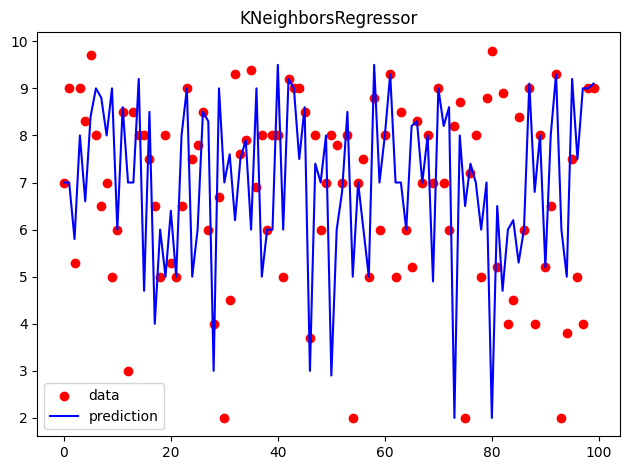

In [99]:
dt_regression = HandmadeDecisionTreeRegressor()
dt_model_regression = dt_regression.fit(X_train_regression, y_train_regression)

dt_predictions_regression = dt_regression.predict(X_test_regression)

mae = mean_absolute_error(y_test_regression, dt_predictions_regression)
print(f"MAE: {mae}")

count = 100

plt.scatter(np.arange(0, len(y_test_regression))[0:count], list(y_test_regression)[0:count], color="red", label="data")
plt.plot(np.arange(0, len(y_test_regression))[0:count], dt_predictions_regression[0:count], color="blue", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("KNeighborsRegressor")

plt.tight_layout()
plt.show()

Обрезка датасета

In [101]:
scaler = StandardScaler()

opt_games_trim = opt_games.iloc[0:1000]

opt_y_regression = opt_games_trim['score']
opt_X_regression = opt_games_trim.drop(['score'], axis = "columns")

simpleimputer = SimpleImputer(strategy='mean')
opt_X_regression = pd.DataFrame(simpleimputer.fit_transform(opt_X_regression))

opt_X_train_regression, opt_X_test_regression, opt_y_train_regression, opt_y_test_regression = train_test_split(opt_X_regression, opt_y_regression, test_size = 0.1, random_state = 228, shuffle = True)

Улучшенный бейзлайн (без кросс-валидации)

MAE: 1.7692083333333333


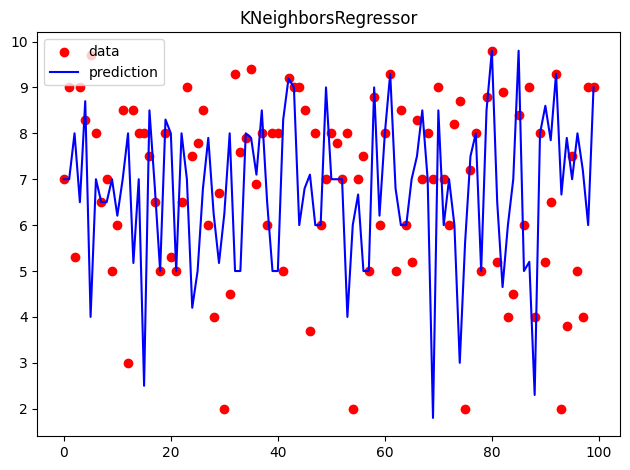

In [102]:
opt_dt_regression = HandmadeDecisionTreeRegressor()
opt_dt_model_regression = opt_dt_regression.fit(opt_X_train_regression, opt_y_train_regression)

opt_dt_predictions_regression = opt_dt_regression.predict(opt_X_test_regression)

mae = mean_absolute_error(opt_y_test_regression, opt_dt_predictions_regression)
print(f"MAE: {mae}")

count = 100

plt.scatter(np.arange(0, len(opt_y_test_regression))[0:count], list(opt_y_test_regression)[0:count], color="red", label="data")
plt.plot(np.arange(0, len(opt_y_test_regression))[0:count], opt_dt_predictions_regression[0:count], color="blue", label="prediction")
plt.axis("tight")
plt.legend()
plt.title("KNeighborsRegressor")

plt.tight_layout()
plt.show()

Выводы:

1) Решающие деревья справились в среднем хуже чем предыдущие алгоритмы, но при этом все еще на уровне с ними.

2) Кросс-валидация погубила recall у улучшенного бейзлайна. Могу предположить, что ни одни гиперпараметры не дали accuracy выше, чем тот, который делает recall в 0. Такие случаи нужно тоже контролировать в реальных задачах.

3) В этот раз Handmade оказался титанически долгим. По 5 минут работали классификации на датасете, обрезанном до 1000 строк (с подмешиванием бОльшего числа популярных треков, для лучшей обучаемости). Соответственно, на малом датасете, самостоятельные реализации показали себя хуже всего, что было.

4) На простой обрезке датасета классификация показала ошеломительную accuracy в 1.0. Это было связано с тем, что в 1000 треков почти нет популярных, и бывало, что в тестовую выборку ни один не попадал. Был соблазн оставить всё так, но решил вручную увеличить частоту появления популярных треков.